# DCGANの作成
mnistの７，８の画像を使ってGANを作る

# 5.1 学習目標

1.	Generatorが画像を生成するためにどのようなニューラルネットワークの構造になっているのかを理解する
2.	Discriminatorが画像の識別をするためにどのようなニューラルネットワークの構造になっているのかを理解する
3.	GANの一般的な損失関数の形とニューラルネットワークの学習の流れを理解する
4.	DCGANのネットワークを実装できるようになる

# 5.2 学習目標

1.	GANの損失関数の形を理解する
2.	DCGANを実装し、手書き数字画像が生成できる

## Library

In [1]:
# パッケージのimport
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

In [2]:
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

## Deconvolution(ConvTranspose2d, 転置畳み込み)

In [3]:
input = torch.tensor([[[[1., 1.], [2., 2.]]]])
print("入力データ")
print(input)
print("-----")

print("通常の畳み込み")
m = nn.Conv2d(1, 1, 2, stride=1, bias=False)
m.weight[0, 0, 0, 0] = 1
m.weight[0, 0, 0, 1] = 2
m.weight[0, 0, 1, 0] = 3
m.weight[0, 0, 1, 1] = 4
print("カーネル")
print(m.weight)
print("出力")
print(m(input))

print("-----")
print("転置畳み込み")
m = nn.ConvTranspose2d(1, 1, 2, stride=1, bias=False)
m.weight[0, 0, 0, 0] = 1
m.weight[0, 0, 0, 1] = 2
m.weight[0, 0, 1, 0] = 3
m.weight[0, 0, 1, 1] = 4
print("カーネル")
print(m.weight)
print("出力")
print(m(input))

入力データ
tensor([[[[1., 1.],
          [2., 2.]]]])
-----
通常の畳み込み
カーネル
Parameter containing:
tensor([[[[1., 2.],
          [3., 4.]]]], grad_fn=<CopySlices>)
出力
tensor([[[[17.]]]], grad_fn=<MkldnnConvolutionBackward>)
-----
転置畳み込み
カーネル
Parameter containing:
tensor([[[[1., 2.],
          [3., 4.]]]], grad_fn=<CopySlices>)
出力
tensor([[[[ 1.,  3.,  2.],
          [ 5., 13.,  8.],
          [ 6., 14.,  8.]]]], grad_fn=<SlowConvTranspose2DBackward>)


## Generatorの実装

In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim=20, image_size=64):
        super(Generator, self).__init__()
        
        # ConvTranspose2dでchannelのサイズを1まで落としていく
        # 白黒画像なので出力チャネルは一つだけ
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(z_dim, image_size*8, kernel_size=4, stride=1), 
            nn.BatchNorm2d(image_size*8), 
            nn.ReLU(inplace=True))
        
        self.layers2 = nn.Sequential(
                nn.ConvTranspose2d(image_size*8, image_size*4, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(image_size*4),
                nn.ReLU(inplace=True))

        self.layers3 = nn.Sequential(
                nn.ConvTranspose2d(image_size*4, image_size*2, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(image_size*2),
                nn.ReLU(inplace=True))
        
        self.layers4 = nn.Sequential(
                nn.ConvTranspose2d(image_size*2, image_size, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(image_size),
                nn.ReLU(inplace=True))
        
        self.last = nn.Sequential(
                nn.ConvTranspose2d(image_size, 1, kernel_size=4, stride=2, padding=1),
                nn.Tanh())
        
    def forward(self, z):
        out = self.layer1(z)
        out = self.layers2(out)
        out = self.layers3(out)
        out = self.layers4(out)
        out = self.last(out)
        
        return out
        

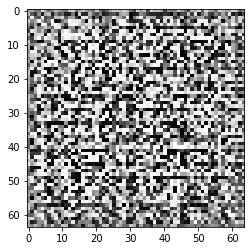

(64, 64)


In [5]:
# 動作確認
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(z_dim=20, image_size=64)

# 入力する乱数
input_z = torch.randn(1, 20)
# torch.Size([1, 20, 1, 1])  N,C,H,Wの形に変形
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)  

# 偽画像を出力
fake_images = G(input_z)
img_transformed = fake_images[0][0].detach().numpy()  # 勾配情報を切り捨ててnumpyに変換
plt.imshow(img_transformed, 'gray')
plt.show()

print(img_transformed.shape) # 1,1 -> 64, 64

## Discriminatorの実装

In [8]:
class Discriminator(nn.Module):
    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()
        
        # 白黒と画像なので最初channelは１
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, image_size, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(image_size, image_size*2, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(image_size*2, image_size*4, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(image_size*4, image_size*8, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        
        # 最終的に偽物か本物か判断するので１次元にする
        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)
        
        return out

In [9]:
# 動作確認
D = Discriminator(z_dim=20, image_size=64)

# 偽画像生成
input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)  
fake_images = G(input_z)

d_out = D(fake_images)
print(d_out.size())  # torch.Size([1,1,1,1])

# 出力にsigmoidをかけて0-1に変換
print(nn.Sigmoid()(d_out))

# Discriminatorがまだ学習してないので偽とも本物とも判別できないので0.5あたりの値になる

torch.Size([1, 1, 1, 1])
tensor([[[[0.4974]]]], grad_fn=<SigmoidBackward>)


## 損失関数
GeneratorとDiscriminatorの損失を足したものがGANのモデルの損失となる

In [ ]:
# Discriminatoｒの損失関数のイメージ実装
# 普通の画像分類とほぼ同じ

# 正解ラベルと偽ラベルを作成
mini_batch_size = 2
label_real = torch.full((mini_batch_size,), 1)
label_fake = torch.full((mini_batch_size,), 0)

# 損失関数の定義
# Binary Cross Entropy : 二値分類の誤差関数
# WithLogistic : ロジスティック関数をかける　の意味
criterion = nn.BCEWithLogitsLoss(reduction='mean')

# 真の画像を判定
d_out_real = D(x)

# 偽の画像を生成して判定
input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)  
fake_images = G(input_z)
d_out_fake = D(fake_images)

# 誤差を計算
d_loss_real = criterion(d_out_real.view(-1), label_real)
d_loss_f　ake = criterion(d_out_fake.view(-1), label_fake)
d_loss = d_loss_fake + d_loss_real

In [ ]:
# Genaratornの損失関数のイメージ実装
# maximize log(1-D(G(z)))

# 偽の画像を生成して判定
input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)  
fake_images = G(input_z)
d_out_fake = D(fake_images)

# 誤差（騙す側目線のloss）
g_loss = criterion(d_out_fake.view(-1), label_real)

## DataLoaderの作成

In [12]:
def make_datapath_list():
    """
    学習の画像データへのファイルパスリストを作成
    """
    
    train_img_list = []
    for img_idx in range(200):
        img_path = './data/img_78/img_7_' + str(img_idx) + '.jpg'
        train_img_list.append(img_path)
        
        img_path = './data/img_78/img_8_' + str(img_idx) + '.jpg'
        train_img_list.append(img_path)
        
    return train_img_list

In [14]:
class ImageTransform():
    """画像の前処理クラス"""
    
    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        
    def __call__(self, img):
        return self.data_transform(img)

In [16]:
class GAN_Img_Dataset(data.Dataset):
    '''
    画像のDatasetクラス
    '''
    
    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        """
        画像のTensor形式のデータを取得
        """
        img_path = self.file_list[index]
        img = Image.open(img_path)  # 高さ、幅、色【白黒】
        
        # 画像の前処理
        img_transformed = self.transform(img)
        
        return img_transformed

In [23]:
# DataLoaderの作成と動作確認

# ファイルリストの作成
train_img_list = make_datapath_list()

# Datasetを作成
mean  = (0.5,)  # カンマがないとエラーになる
std = (0.5,)
train_dataset = GAN_Img_Dataset(file_list=train_img_list, transform=ImageTransform(mean, std))

# DataLoaderの作成
batch_size = 64
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 動作の確認
batch_iterator = iter(train_dataloader)  # イテレータに変換
images = next(batch_iterator)
print(images.size())  # torch.Size([])


torch.Size([64, 1, 64, 64])


## 学習させる

In [24]:
# ネットワークの初期化
def weights_init(m):
    classname = m.__class__.__name__  # オブジェクトのクラス名を取得
    if classname.find('Conv') != -1:  # 文字列中の任意の文字列の位置を取得　含まれていなければ-1
        # Conv2dとConvTranspose2dの重みの初期化
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        # BatchNorm2dの重みの初期化
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
# 重みの初期化の実施
G.apply(weights_init)
D.apply(weights_init)

print('ネットワークの初期化完了')

ネットワークの初期化完了


In [28]:
# GANを学習させる関数

def train_model(G, D, dataloader, num_epochs):
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)
    
    # 最適化手法
    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])
    
    # 誤差関数を定義
    criterion = nn.BCEWithLogitsLoss(reduction='mean')
    
    # パラメータをハードコーディング
    z_dim=20
    mini_batch_size = 64
    
    G.to(device)
    D.to(device)
    G.train()
    D.train()
    
    torch.backends.cudnn.benchmark = True
    
    # 画像の枚数
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    
    # イテレーションカウンタのセット
    iteration = 1
    logs = []
    
    # epochのループ
    for epoch in range(num_epochs):
        t_epoch_start = time.time()
        epoch_g_loss = 0.0
        epoch_d_loss = 0.0
        
        print('-------------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')
        print('(train)')
        
        # データローダからminibatchずつ取り出すループ
        for images in dataloader:
            
            # ------------------------
            # Discriminator
            # ------------------------
            if images.size()[0] == 1:
                continue
            
            images.to(device)
            
            # 正解ラベルと偽ラベルを作成
            # epochの最後のイテレーションはミニバッチの数が少なくなるのでdataloaderから撮ってきたデータのサイズをminibatch_sizeとする
            mini_batch_size = images.size()[0]
            label_real = torch.full((mini_batch_size, ), 1).to(device)
            label_fake = torch.full((mini_batch_size, ), 0).to(device)
            
            # 真の画像を判定
            d_out_real = D(images)
            
            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)
            
            # 誤差を計算
            # Discriminatorなので偽物を偽物と判定しているか、本物を本物と判定しているかが指標になる
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake
            
            # 逆伝播
            g_optimizer.zero_grad()  # Generatorのパラメータ更新の際の勾配を0にする
            d_optimizer.zero_grad()  # Discriminatorのパラメータ更新の際の勾配を0にする
            
            d_loss.backward()
            d_optimizer.step()
            
            # ------------------------
            # Generator
            # ------------------------
            # 偽の画像を生成して判定  再度偽の画像を生成する意味はあるのだろうか？上の使いまわしでよいのでは？
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)
            
            # 誤差を計算
            g_loss = criterion(d_out_fake.view(-1), label_real)
            
            # 逆伝播
            g_optimizer.zero_grad()  # Generatorのパラメータ更新の際の勾配を0にする
            d_optimizer.zero_grad()  # Discriminatorのパラメータ更新の際の勾配を0にする
            
            g_loss.backward()
            g_optimizer.step()
            
            # ------------------------
            # 記録
            # ------------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1
            
        # epochのphaseごとのloss
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} || Epoch_G_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
        print('timer: {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()
        
    return G, D
        
        
        

In [29]:
# 学習・検証を実行する
# CPUだと１時間位
num_epochs = 200
G, D = train_model(G, D, dataloader=train_dataloader, num_epochs=num_epochs)

使用デバイス： cpu
-------------
Epoch 1/200
-------------
(train)
-------------
epoch 0 || Epoch_D_Loss:0.0920 || Epoch_G_Loss:0.1421
timer: 19.0746 sec.
-------------
Epoch 2/200
-------------
(train)
-------------
epoch 1 || Epoch_D_Loss:0.0546 || Epoch_G_Loss:0.2184
timer: 18.8428 sec.
-------------
Epoch 3/200
-------------
(train)
-------------
epoch 2 || Epoch_D_Loss:0.0049 || Epoch_G_Loss:0.4397
timer: 19.2590 sec.
-------------
Epoch 4/200
-------------
(train)
-------------
epoch 3 || Epoch_D_Loss:0.0075 || Epoch_G_Loss:0.7278
timer: 19.5242 sec.
-------------
Epoch 5/200
-------------
(train)
-------------
epoch 4 || Epoch_D_Loss:0.4460 || Epoch_G_Loss:0.2342
timer: 19.3918 sec.
-------------
Epoch 6/200
-------------
(train)
-------------
epoch 5 || Epoch_D_Loss:0.0079 || Epoch_G_Loss:0.3456
timer: 19.5203 sec.
-------------
Epoch 7/200
-------------
(train)
-------------
epoch 6 || Epoch_D_Loss:0.0028 || Epoch_G_Loss:0.4576
timer: 19.0717 sec.
-------------
Epoch 8/200
----------

-------------
epoch 60 || Epoch_D_Loss:0.1125 || Epoch_G_Loss:0.1484
timer: 19.0157 sec.
-------------
Epoch 62/200
-------------
(train)
-------------
epoch 61 || Epoch_D_Loss:0.1515 || Epoch_G_Loss:0.1888
timer: 19.2291 sec.
-------------
Epoch 63/200
-------------
(train)
-------------
epoch 62 || Epoch_D_Loss:0.1047 || Epoch_G_Loss:0.1237
timer: 19.2342 sec.
-------------
Epoch 64/200
-------------
(train)
-------------
epoch 63 || Epoch_D_Loss:0.1000 || Epoch_G_Loss:0.1522
timer: 19.4096 sec.
-------------
Epoch 65/200
-------------
(train)
-------------
epoch 64 || Epoch_D_Loss:0.1082 || Epoch_G_Loss:0.1501
timer: 19.2159 sec.
-------------
Epoch 66/200
-------------
(train)
-------------
epoch 65 || Epoch_D_Loss:0.1005 || Epoch_G_Loss:0.1688
timer: 19.2514 sec.
-------------
Epoch 67/200
-------------
(train)
-------------
epoch 66 || Epoch_D_Loss:0.0915 || Epoch_G_Loss:0.1646
timer: 19.1112 sec.
-------------
Epoch 68/200
-------------
(train)
-------------
epoch 67 || Epoch_D_

-------------
epoch 120 || Epoch_D_Loss:0.0748 || Epoch_G_Loss:0.2560
timer: 19.0384 sec.
-------------
Epoch 122/200
-------------
(train)
-------------
epoch 121 || Epoch_D_Loss:0.0668 || Epoch_G_Loss:0.2637
timer: 18.9741 sec.
-------------
Epoch 123/200
-------------
(train)
-------------
epoch 122 || Epoch_D_Loss:0.0668 || Epoch_G_Loss:0.2567
timer: 19.2574 sec.
-------------
Epoch 124/200
-------------
(train)
-------------
epoch 123 || Epoch_D_Loss:0.0779 || Epoch_G_Loss:0.2668
timer: 19.0759 sec.
-------------
Epoch 125/200
-------------
(train)
-------------
epoch 124 || Epoch_D_Loss:0.0643 || Epoch_G_Loss:0.2446
timer: 19.0453 sec.
-------------
Epoch 126/200
-------------
(train)
-------------
epoch 125 || Epoch_D_Loss:0.0547 || Epoch_G_Loss:0.3225
timer: 19.0469 sec.
-------------
Epoch 127/200
-------------
(train)
-------------
epoch 126 || Epoch_D_Loss:0.0880 || Epoch_G_Loss:0.2174
timer: 19.4556 sec.
-------------
Epoch 128/200
-------------
(train)
-------------
epoch 

-------------
epoch 179 || Epoch_D_Loss:0.0362 || Epoch_G_Loss:0.3583
timer: 19.2123 sec.
-------------
Epoch 181/200
-------------
(train)
-------------
epoch 180 || Epoch_D_Loss:0.0411 || Epoch_G_Loss:0.3890
timer: 18.9371 sec.
-------------
Epoch 182/200
-------------
(train)
-------------
epoch 181 || Epoch_D_Loss:0.0727 || Epoch_G_Loss:0.3844
timer: 19.2183 sec.
-------------
Epoch 183/200
-------------
(train)
-------------
epoch 182 || Epoch_D_Loss:0.0412 || Epoch_G_Loss:0.3319
timer: 19.1547 sec.
-------------
Epoch 184/200
-------------
(train)
-------------
epoch 183 || Epoch_D_Loss:0.0261 || Epoch_G_Loss:0.4177
timer: 19.0849 sec.
-------------
Epoch 185/200
-------------
(train)
-------------
epoch 184 || Epoch_D_Loss:0.0341 || Epoch_G_Loss:0.3660
timer: 19.1600 sec.
-------------
Epoch 186/200
-------------
(train)
-------------
epoch 185 || Epoch_D_Loss:0.0437 || Epoch_G_Loss:0.3976
timer: 19.0789 sec.
-------------
Epoch 187/200
-------------
(train)
-------------
epoch 

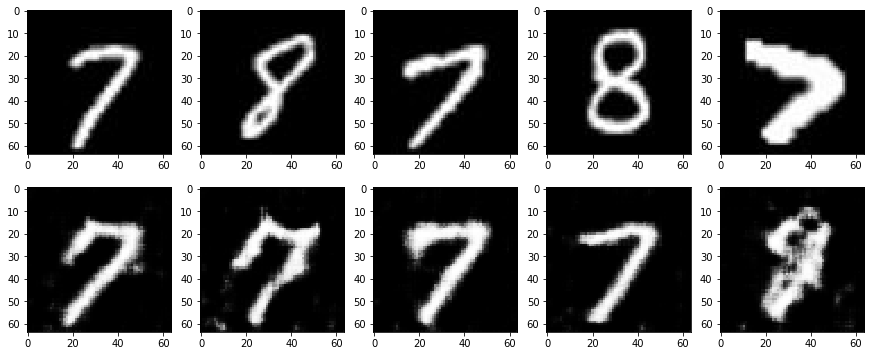

In [44]:
# 生成画像と訓練データを可視化する

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 入力の乱数生成
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

# 画像生成
G.eval()
fake_images = G(fixed_z.to(device))

# 訓練データ
batch_iterator = iter(train_dataloader)
images = next(batch_iterator)

# 出力
fig = plt.figure(figsize=(15, 6))
for i in range(0,5):
    # 上段に訓練データ
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i][0].cpu().detach().numpy(), 'gray')
    
    # 下段に生成データ
    plt.subplot(2, 5, i+6)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')

epochをこれ以上増やすとGは7の画像しか生成しなくなる<br>
8に比べて7のほうが単純でDを騙す画像を生成しやすいから<br>
教師データの一部しか生成しなくなる現象をモード崩壊という